# Import stuff

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Load dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# tf.distribute

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/cpu:0", "/cpu:1", "/cpu:2"])

with mirrored_strategy.scope():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    model.summary()

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=3,
                    validation_data=(test_images, test_labels))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1', '/job:localhost/replica:0/task:0/device:CPU:2')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________

In [4]:
# check do we have 3 parallel processes
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/cpu:0", "/cpu:1", "/cpu:2"])

with mirrored_strategy.scope():
    x = tf.Variable(1.)
    
print('\nNumber of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
x

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1', '/job:localhost/replica:0/task:0/device:CPU:2')

Number of devices: 3


MirroredVariable:{
  0: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
  1: <tf.Variable 'Variable/replica_1:0' shape=() dtype=float32, numpy=1.0>,
  2: <tf.Variable 'Variable/replica_2:0' shape=() dtype=float32, numpy=1.0>
}

# Plot and accuracy

313/313 - 3s - loss: 1.0106 - accuracy: 0.6506


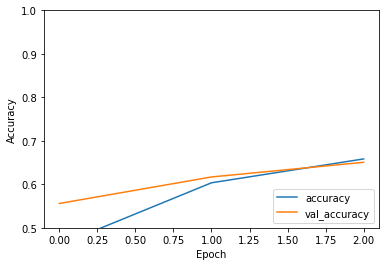

In [5]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [6]:
print(f'Accuracy on test dataset: {test_acc:.4f}')

Accuracy on test dataset: 0.6506
